In [1]:
import matplotlib.pyplot as plt
import sys
sys.path.append('..')  # 文件位于

import factors  # 因子计算
import data_utils  # 数据读取
import performance as perf  # IC计算
import plotting  #绘图

In [3]:
dl = data_utils.DataLoader()
dl.init_month_df('../data/15m_data/')
# 计算未来收益率
data_utils.compute_future_rtn_for_all(dl)

In [4]:
import pandas as pd
import numpy as np

In [5]:
def cal_Z_score(factor_df, column_lists, span):
    '''Z-score'''
    for column_name in column_lists:
        mean_20 = factor_df[column_name].ewm(span, adjust=False).mean()
        std_20 = factor_df[column_name].ewm(96, adjust=False).std()  # todo 超参数搜索
        factor_df[f'{column_name}_Z'] = (factor_df[column_name].values - mean_20) / std_20
    return factor_df

@factors.handle_dataloader_data
def add_close_Z(raw_df:pd.DataFrame)-> pd.DataFrame:
    raw_df = cal_Z_score(raw_df, ['close'], 30)
    return raw_df

In [ ]:
@factors.handle_dataloader_data
def add_new_factor(raw_df:pd.DataFrame)-> pd.DataFrame:
    '''
    加入新因子的模板。
    :param raw_df: 原始数据
    :param factor_name: 因子名称
    :return: 原始数据+因子
    '''
    data_df = raw_df[['open', 'close', 'high', 'low', 'volume','taker_buy_volume']]
    data_df.index = pd.to_datetime(raw_df.open_time, unit='ms')
    temp_factor_df = pd.DataFrame()  # 暂存特征，避免index不一致导致的错误
    temp_factor_df['trend_adx'] = adx(data_df['high'], data_df['low'], data_df['close'])['ADX_14']
    temp_factor_df['trend_cci'] = cci(data_df['high'], data_df['low'], data_df['close'])
    temp_factor_df['macd'] = macd(data_df['close'])['MACD_12_26_9']
    temp_factor_df['momentum_rsi'] = rsi(data_df['close'])
    temp_factor_df['volume_obv'] = obv(data_df['close'], data_df['volume'])
    temp_factor_df['volume_vwap'] = vwap(data_df['high'], data_df['low'], data_df['close'], data_df['volume'])
    temp_factor_df['volatility_atr'] = atr(data_df['high'], data_df['low'], data_df['close'])
    temp_factor_df['bop'] = bop(data_df['open'], data_df['high'], data_df['low'],
                            data_df['close'])  # (open - close)/(high - low)
    temp_factor_df['ohlc4'] = ohlc4(data_df['open'], data_df['high'], data_df['low'], data_df['close'])
    temp_factor_df['buy_taker_prop'] = data_df['taker_buy_volume']/data_df['volume']
    temp_factor_df.reset_index(drop=True, inplace=True)
    raw_df = pd.concat([raw_df, temp_factor_df], axis=1)

    raw_df = cal_Z_score(raw_df, ['volume_obv', 'volume_vwap', 'bop', 'ohlc4'], 30)
        
    return raw_df

In [7]:
# 计算因子
add_new_factor(dl)
add_close_Z(dl)

In [8]:
from ml_performance import MLFactorEvaluator

In [9]:
record_names = ['baseline', 'setA', 'setB', 'setC']

In [10]:
factor_names = [
    ['macd', ],
    ['momentum_rsi'],
    ['macd', 'momentum_rsi', 'buy_taker_prop', 'volatility_atr'],
    ['trend_adx', 'trend_cci', 'volume_obv_Z', 'volume_vwap_Z', 'bop', 'ohlc4_Z', 'close_Z', 'volatility_atr'],
]

In [11]:
from sklearn.ensemble import RandomForestClassifier

In [12]:
params = {
    'n_jobs' : -1,
    'max_depth' : 10,
    'n_estimators' : 50
}

In [13]:
ml_evaluator = MLFactorEvaluator(
    method = RandomForestClassifier, 
    record_names = record_names, 
    factor_names = factor_names,
    params_dict = params
)

In [14]:
ml_evaluator.evaluate(dl, 'fwd_rtn_20_bool')

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:09<00:00,  6.95s/it]


In [15]:
ml_record = ml_evaluator.get_assess_df('f1')

In [16]:
plotting.plot_ML_table(ml_record)

Machine Learning records


,0,1,2,3,4,5,6,7,8,9,mean,std
baseline,0.6342,0.5876,0.5971,0.6312,0.6308,0.6340,0.6007,0.6451,0.6164,0.5984,0.6176,0.0201
setA,0.4786,0.5516,0.5244,0.4966,0.4990,0.5216,0.4909,0.5953,0.5831,0.5434,0.5284,0.0395
setB,0.6350,0.5895,0.5970,0.6279,0.6300,0.6312,0.6021,0.6463,0.6172,0.5967,0.6173,0.0196
setC,0.6356,0.5861,0.5887,0.6094,0.6237,0.6359,0.5927,0.6466,0.6224,0.6000,0.6141,0.0218


Machine Learning T-test Analysis


,t_ind,p_ind,t_rel,p_rel
record_name,,,,
setA,6.3565,0.0000,6.2666,0.0001
setB,0.0299,0.9765,0.4589,0.6572
setC,0.3666,0.7182,1.3412,0.2127


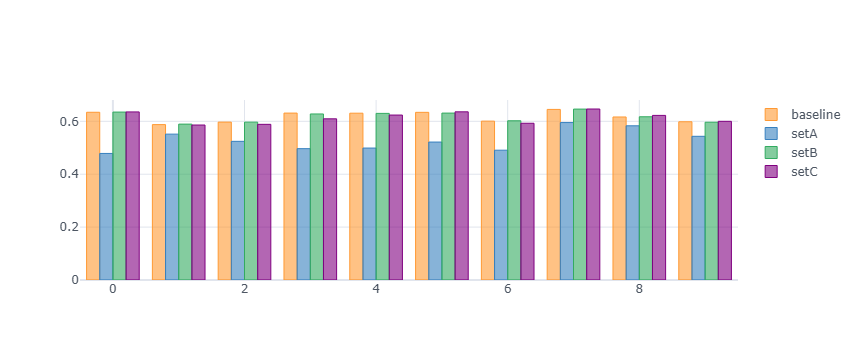

In [17]:
plotting.plot_ML_records(ml_record)